Tester notebook just to make sure sequential application of `extract_latents` and `make_canvas` works.

In [1]:
from mcmc_visanagrams.views import VIEW_MAP
from mcmc_visanagrams.if_pipeline import extract_latents, make_canvas

import matplotlib.pyplot as plt
import torch
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
# Make a dummy context

guidance_mag = 20

context = {
    (2, 0, 0): [{
        "string": "a drawing of a penguin",
        "magnitude": guidance_mag,
        "view": "identity"
    }, {
        "string": "a drawing of a giraffe",
        "magnitude": guidance_mag,
        "view": "rotate_180"
    }]
}

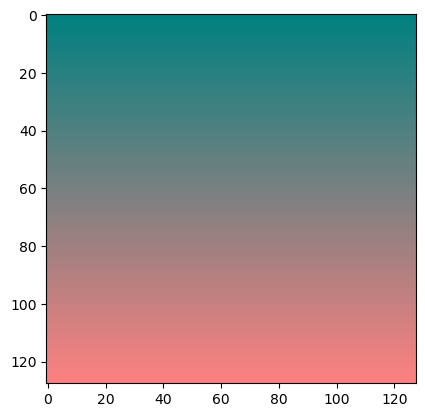

In [19]:
# Make a dummy picture

img_height = 128
img_width = 128

img_channel_green = np.arange(img_height).reshape(img_height, 1).repeat(img_width, axis=1).astype(
    np.uint8) * 2
img_channel_br = np.ones((img_height, img_width), dtype=np.uint8) * 128
# img = img_channel[:, :, None].repeat(3, axis=2) + (128 // 2)
img = np.stack((img_channel_green, img_channel_br, img_channel_br), axis=2)

# print(img)
plt.figure()
plt.imshow(img)

In [20]:
def img_to_latent(img: np.ndarray) -> torch.Tensor:
    latent = torch.from_numpy(img)
    if len(latent.shape) == 3:
        latent = latent.unsqueeze(0)
    if latent.shape[-1] != 3:
        raise ValueError("Expected 3 channels and the image layout to be (H, W, C)")

    latent = latent.to(torch.double).permute(0, 3, 1, 2)
    latent = (latent / 255 * 2 - 1)
    return latent


def latent_to_img(latent: torch.Tensor) -> np.ndarray:
    if len(latent.shape) == 4:
        if latent.shape[0] != 1:
            raise ValueError("Expected batch size of 1")
        latent = latent[0]
    if latent.shape[0] != 3:
        raise ValueError("Expected 3 channels and the image layout to be (C, H, W)")

    img = latent.permute(1, 2, 0)
    img = ((img + 1) / 2 * 255).clamp(0, 255).to(torch.uint8).cpu().numpy()
    return img

In [21]:
# Now, prep the image like it would be represented in the pipeline
# It's expected that the height,width channels are last.
latent = img_to_latent(img)
img_test = latent_to_img(latent)


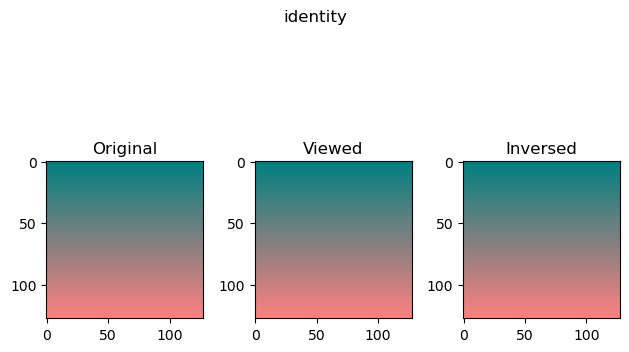

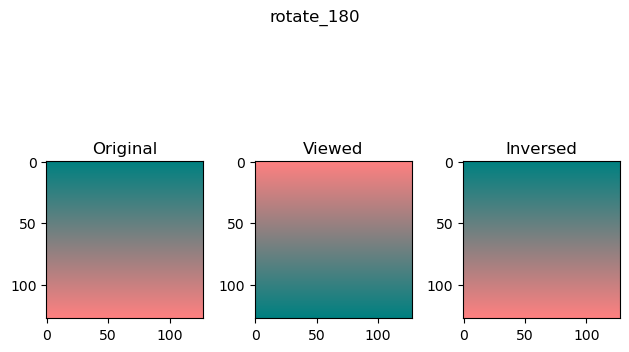

In [22]:
# Check that application of views works outside of the pipeline.
for size, ctx in context.items():
    if isinstance(ctx, list):
        # Means we have multiple views for the same sub-image.
        # NOTE: Hand-waving the extraction of the sub-image here.
        # NOTE: Expected format is channel in zeroth dimension
        subimg = latent  #.clone()
        for d in ctx:
            view_str = d["view"]
            view = VIEW_MAP[view_str]()
            # print(view)
            img_viewed = view.view(subimg)  #.clone())
            img_viewed_np = latent_to_img(img_viewed)

            img_unviewed = view.inverse_view(img_viewed)  #.clone())
            img_unviewed_np = latent_to_img(img_unviewed)

            subimg_np = latent_to_img(subimg)

            fig, ax = plt.subplots(1, 3)
            ax[0].imshow(subimg_np)
            ax[0].set_title("Original")
            ax[1].imshow(img_viewed_np)
            ax[1].set_title("Viewed")
            ax[2].imshow(img_unviewed_np)
            ax[2].set_title("Inversed")
            fig.tight_layout()
            fig.suptitle(view_str)


In [7]:
sizes = []
views = []
for size, ctx in context.items():
    if isinstance(ctx, list):
        # Means we have multiple views for the same sub-image.
        # NOTE: Hand-waving the extraction of the sub-image here.
        # NOTE: Expected format is channel in zeroth dimension
        for d in ctx:
            view_str = d["view"]
            view = VIEW_MAP[view_str]()
            sizes.append(size)
            views.append(view)

latents = extract_latents(latent, sizes, views)

Step 0 canvas min: -1.0, max: 0.9921568627450981
Step 1 canvas min: -0.9921568627450981, max: 0.9843137254901962
Step 2 canvas min: -0.9921320490474966, max: 0.9842891079483068
Step 3 canvas min: -0.992107235970482, max: 0.9842644910220988
Step 4 canvas min: -0.9920824235140389, max: 0.9842398747115563
Step 5 canvas min: -0.9920576116781515, max: 0.9842152590166642
Step 6 canvas min: -0.9920328004628046, max: 0.9841906439374069
Step 7 canvas min: -0.9920079898679827, max: 0.9841660294737691
Step 8 canvas min: -0.99198317989367, max: 0.9841414156257355
Step 9 canvas min: -0.9919583705398509, max: 0.9841168023932906
Step 10 canvas min: -0.9919335618065105, max: 0.9840921897764191
Step 11 canvas min: -0.9919087536936326, max: 0.9840675777751056
Step 12 canvas min: -0.9918839462012021, max: 0.9840429663893345
Step 13 canvas min: -0.9918591393292033, max: 0.9840183556190907
Step 14 canvas min: -0.9918343330776206, max: 0.9839937454643587
Step 15 canvas min: -0.9918095274464387, max: 0.98396

Text(0.5, 1.0, 'Step 99')

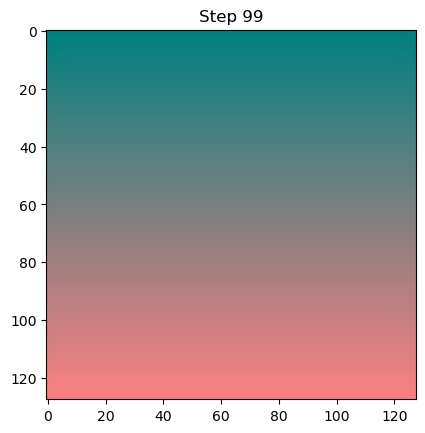

In [23]:
# Repeatedly apply extraction and making of canvas
canvas = latent
for i in range(100):
    print(f"Step {i} canvas min: {canvas.min()}, max: {canvas.max()}")
    lats = extract_latents(canvas, sizes, views)
    canvas = make_canvas(lats, 128, sizes, views=views)
img_test = latent_to_img(canvas)
plt.figure()
plt.imshow(img_test)
plt.title(f"Step {i}")

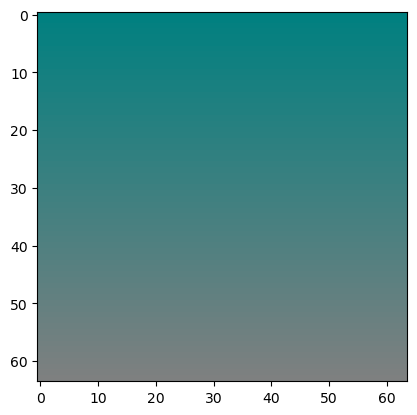

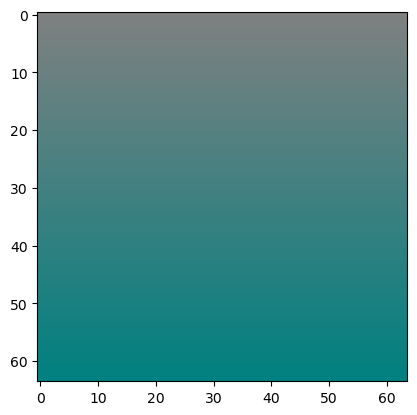

In [8]:
for lat in latents:
    plt.figure()
    plt.imshow(latent_to_img(lat))

In [9]:
canvas = make_canvas(latents, 128, sizes, views=views)

/home/dcolli23/miniconda3/envs/mcmc_visanagrams/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987277512/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
canvas_np = latent_to_img(canvas)

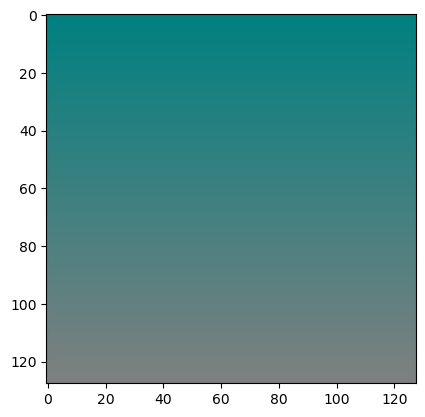

In [14]:
plt.figure()
plt.imshow(canvas_np)

In [12]:
canvas_np

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)